In [1]:
import torch
from PIL import Image
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm

In [2]:
# Video
checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

In [3]:
video_dir_in = r"N:\Projekte\ZIM_Amaize-Q\14_Karsten_Analyse\20250603_ICAM25_EOT_Geometry01"
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "frames/lpbf"

frame_names = [
    p for p in os.listdir(video_dir_in)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(p.split("_")[1]))

offset = 1000
for index, frame in enumerate(tqdm(frame_names[offset:1100])):
    image_path = os.path.join(video_dir_in, frame)
    img = cv2.imread(image_path)
    crop_img = img[500:730, 130:900]
    # cv2.imshow('image', crop_img)
    # cv2.waitKey(0)
    cv2.imwrite(f"{video_dir}/{str(index+offset).zfill(4)}.jpg", crop_img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


In [4]:
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
# frame_names.sort(key=lambda p: int(p.split(".")[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'frames/lpbf'

In [5]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.96it/s]


In [9]:
# In case any inference has run
# predictor.reset_state(inference_state)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [7]:
ann_frame_idx_1 = 0

points_bauteil_1 = np.array([
    [70, 65],
    [700, 100],
], dtype=np.float32)
labels_bauteil_1 = np.array([1, 1], np.int32)


_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx_1,
    obj_id=1,
    points=points_bauteil_1,
    labels=labels_bauteil_1,
)

C:\Users\scheibe\Documents\code\fg-hybrid\LPBF_Points\sam2\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (C:\Users\scheibe\Documents\code\fg-hybrid\LPBF_Points\sam2\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


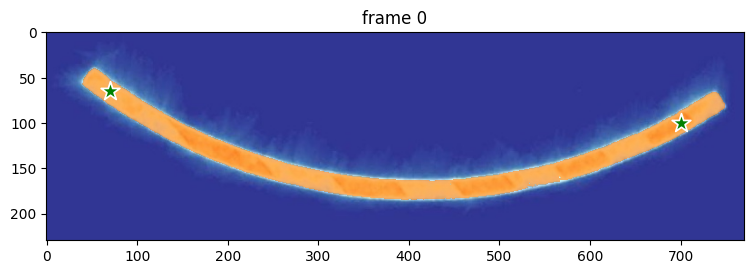

In [8]:
# show the results on the current (interacted) frame
plt.close()

_, ax = plt.subplots(figsize=(9, 6))
ax.set_title(f"frame {ann_frame_idx_1}")
ax.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx_1])))
show_points(points_bauteil_1, labels_bauteil_1, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [8]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.28s/it]


In [16]:
# import pickle

# with open('lpbf_segmented_0_100.pkl', 'wb') as f:
#     pickle.dump(video_segments, f)

In [40]:
plt.close("all")
for out_frame_idx in range(0, 101):
    # fig, ax = plt.subplots()
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        h, w = out_mask.shape[-2:]
        mask_image = out_mask.reshape(h, w, 1) * np.array([255])
        cv2.imwrite(f"frames/lpbf_mask/{str(out_frame_idx).zfill(4)}.jpg", mask_image)
        # ax.imshow(mask_image, cmap="binary_r")